# Out-of-plane failure calculations
### F-Mechanism Parish House West Facade 


Author: Aline F. Bönzli

Master Thesis 2023/2024

Supervisors: Prof. Dr. Katrin Beyer, Dr. Igor Tomic

Co-author: Caroline L. Heitmann

Caroline and I intensely collaborated on the elaboration of various notebooks for different OOP mechanisms, generic and specifically applied to our respective buildings treated in our theses.

## Introduction

This notebook can be used to calculate the push-over curve for an out-of-plane mechanisms of a masonry structure subject to seismic action. The mechanism in question is a F-mechanism (D'Ayala, 2002) and the calculations were performed for the west facade of the Parish House at St. Lawrence Church in Petrinja, Croatia.

First, the geometric and material characteristics will be defined, then depending on these inputs, the displacement capacity for out-of-plane accelerations will be returned in form of a push-over graph. 

In [1]:
# Import the basic packages for the notebook
import numpy as np                   # Numerical library
import pandas as pd                  # Data analysis library
import matplotlib.pyplot as plt      # Plotting library
import matplotlib.ticker as maticker # Tick locating and formatting library
import matplotlib.colors as mcolors  # Colours
from sympy.solvers import solvers    # Library to solve equations
from sympy import Symbol, Eq, nsolve # For solving equations
import math

## 1. Define the wall geometry

The chosen example for this code is a wall with two rows of windows and two thicknesses moving out of plane around a mid axis where the wall changes thickness. A sketch with the main dimensions is shown below. At the height where the wall changes thickness, a vault is supported which will add a vertical load, as well a horizontal thrust.

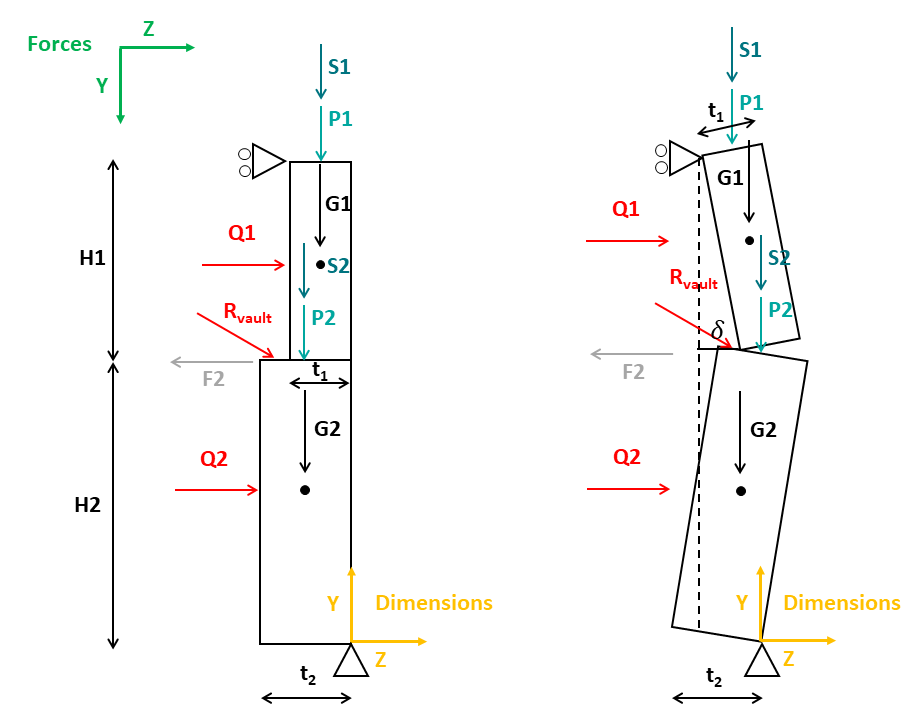

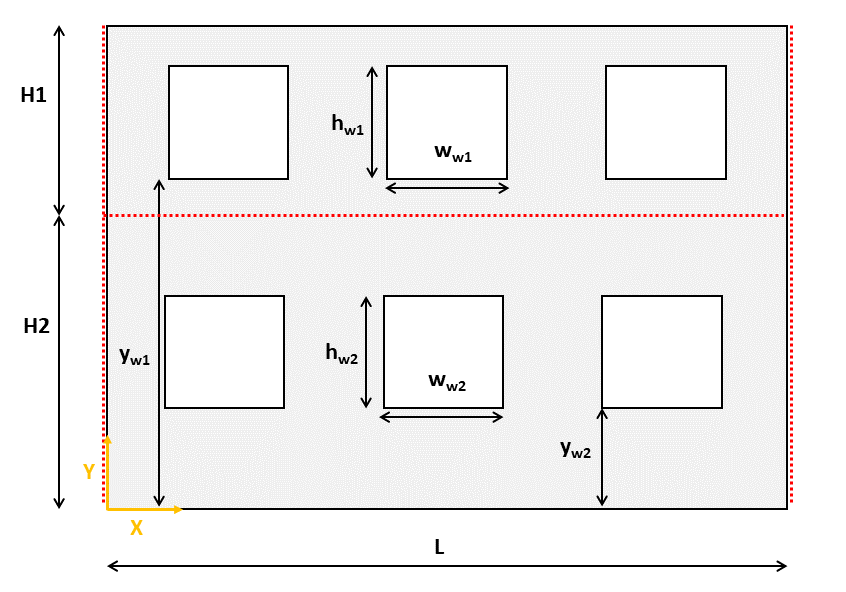

In [2]:
from IPython.display import Image, display
display(Image(filename='Mec_F_3.png'))
display(Image(filename='Mec_F_2.png'))

This block is used to define the geometry of the wall and the windows within.

In [3]:
## Wall geometry
H1 = 3.25           # Height of the upper part of the wall,    y-direction [m]
H2 = 2.75           # Height of the lower part of the wall,    y-direction [m]
L = 14.2            # Total length of wall,                    x-direction [m]
t1 = 0.55           # Thickness of the upper part of the wall, z-direction [m]
t2 = 0.7            # Thickness of the lower part of the wall, z-direction [m]


## Window geometry, upper row
h_w1 = 1.7          # Height of window on upper wall [m]
w_w1 = 1.1          # Width of window on upper wall[m]
y_w1 = 3.65         # Vertical distance from y = 0 to bottom corner of window on upper wall [m]
n_w1 = 4            # Number of windows on upper wall [-]

## Window geometry, lower row
h_w2 = 1.4          # Height of window on lower wall [m]
w_w2 = 1.1          # Width of window on lower wall[m]
y_w2 = 0.7          # Vertical distance from y = 0 to bottom corner of window on lower wall [m]
n_w2 = 4            # Number of windows on lower wall [-]

## Vault geometry
h_v = 0.3           # Height of the vault at mid-span with respect to its support on the wall [m]
w_v = 1.75          # Main span width of the vault [m]
t_v = 0.15          # Thickness of the vault [m]


## Slab information
max_delta = t2/2    # Maximum displacement, when the slab and wall lose connection such that the friction is no longer
                    # restraining the wall [m]

## 2. Define material properties

This block is used to define the material properties of the wall and the connecting slab. In this case the friction coefficient is set to zero since the slab is directly supported by the vault, which is in return in a monolithical connection to the wall.

In [4]:
rho_masonry = 18000         # Density of the masonry [N/m^3]
mu_f = 0.0                  # Friction coefficient between slab and masonry wall 

## 3. Define the loads and forces

In this paragraph, the loads and forces acting on the wall are defined. The following block defines the vertical load on top of the wall coming from a slab (S) or a superimposed wall (P). Note that the S-load will be used to directly calculate the restraining force due to friction between the wall and the slab. If you want to introduce a vertical load that does not produce any friction, please use the P-load.

In [5]:
P1 = 71326                  # vertical load on top of the upper wall [N]
S1 = 67209                  # slab load acting on top of the upper wall [N]
P2 = 26825                  # vertical load on top of the lower wall [N]
S2 = 0                      # slab load acting on top of the lower wall [N]
q_vault = 37769             # surface load acting on vault [N/m]

## 4. Calculation of overturning moment

This paragraph calculates the pushover curve for the given case. 

The maximum forces on each block are: Q1= 153.37kN Q2=166.03kN
After reaching that limit, the wall will start rocking out of plane.
This corresponds to acelerations of acc= 3.93 m/s2
The a-factor is a=0.401
The limit displacement corresponds to 0.091 m. After reaching this displacement the wall loses all resistance.


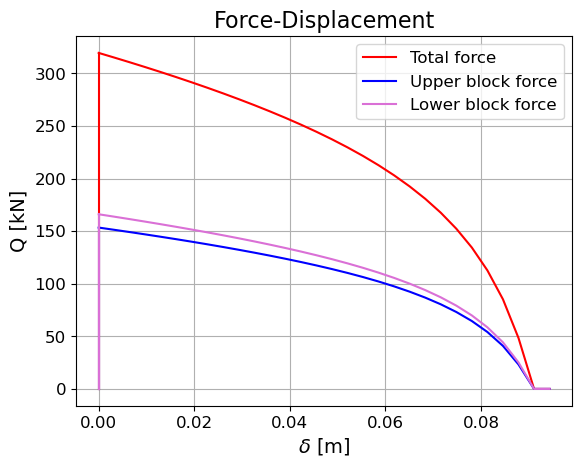

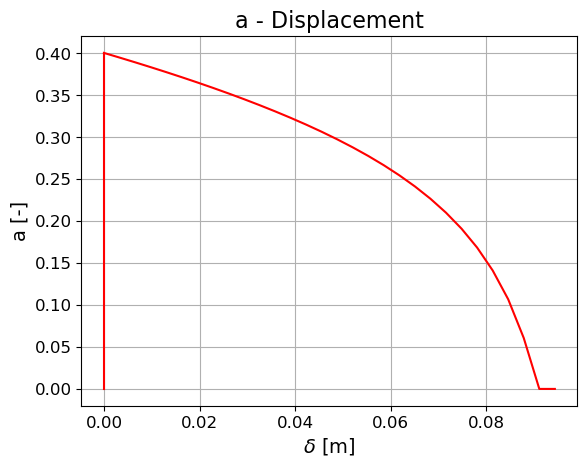

In [6]:
# This function calculates the center of gravity of the wall, y-direction using the following entry values:
def cog_fun(n_w,h_w,y_w,w_w,H,L,y_W):
    # n_w = number of windows in the wall block
    # h_w = height of the windows [m]
    # y_w = distance of ground to lower corner of the windows [m]
    # w_w = width of the windows [m]
    # H   = height of the wall block [m]
    # L   = length of the wall block [m]
    # y_W = height of the lower corner of the wall block above ground [m]
    A_w = n_w*h_w*w_w         # total area of windows [m^2]
    A = H*L                   # area of wall [m^2]
    ybar = H/2                # centroid of wall with respect to its lower corner, assuming 
                              # rectangular profile with constant thickness [m]
    ybar_w = y_w+h_w/2-y_W    # centroid of wall with respect to lower corner of wall, assuming 
                              # rectangular profile with constant thickness [m]
    
    COG_y = ((A*ybar)-(A_w*ybar_w))/(A-A_w)+y_W
    
    return COG_y

# This function calculates the horizontal thrust and the vertical load from the vault:
def vault_fun(delta):
 # delta = displacement of the wall OOP [m]
    
    # defining displaced geometry
    w_v_new = w_v + delta                  # new width of the vault [m]
    l_v = math.sqrt((w_v/2)**2 + h_v**2)   # length of the diagonal connecting the support and the point at
                                           # mid-span of the vault [m]
    if w_v_new >= l_v*2:                   # check if the vault is still in place
        return np.array([0,0])
    else:
        h_v_new = math.sqrt(l_v**2-(w_v_new/2)**2) # new height of the vault [m]

     # calculate support loads           
        R_h = (q_vault * w_v_new**2 /         # horizontal thrust [N]
              (8 * h_v_new))
        R_v = q_vault * w_v_new /2            # vertical support load [N]
        
    return np.array([R_v,R_h])

# In this function we find the alpha value corresponding to the part of the self weight of the
# wall, representing the seismic load (Q1=alpha*G1 and Q2=alpha*G2), for an equilibrium position
# at a given displacement delta
def alpha_fun(delta):

    delta_G1 = delta*(H1+H2-COG_1)/H1                          # Displacement at the COG of the top wall [m]
    delta_G2 = delta*COG_2/H2                                  # Displacement at the COG of the bottom wall [m]
    F2_it = F2
    if delta > H1:
        return [0,0]
    # Verify if the slab at cracking level is still in contact
    if delta > max_delta:
        F2_it=0
    # Calculate the thrust of the vault
    [R_v,R_h] = vault_fun(delta)
    if [R_v,R_h] == [0,0]:
        return [0,0]
    
    a = Symbol('a')
    F1 = Symbol('F1')
    # Equilibrium about the lower support point
    equation1 = Eq( -F1*Htot                                    # Moment from upper support [Nm]
                    -F2_it*H2                                   # Moment from middle slab friction [Nm]
                    +a*G1*COG_1                                 # Moment from seismic load on top block [Nm]
                    +a*G2*COG_2                                 # Moment from seismic load on bottom block [Nm]
                    -(P1+S1)*t1/2                               # Moment from vertical loads on top block [Nm]
                    +(P2+S2+R_v)*(delta-(t2/2))                 # Moment from vertical loads on bottom block [Nm]
                    +G1*(delta_G1-(t1/2))                       # Moment from selfweight of top block [Nm]
                    +G2*(delta_G2-(t2/2))                       # Moment from selfweight of bottom block [Nm]
                    +R_h*H2                                     # Moment from the thrust of the vault [Nm]
                , 0)

    # Equilibrium of the upper body about its rotation corner
    equation2 = Eq( -F1*H1                                      # Moment from upper support [Nm]
                    +a*G1*(COG_1-H2)                            # Moment from seismic load on top block [Nm]
                    +(P1+S1)*(t1/2-delta)                       # Moment from vertical loads on top block [Nm]
                    +G1*(delta_G1+(t1/2)-delta)                 # Moment from selfweight of top block [Nm]
                    ,0)            
   
    # Initial guesses to solve the equation (this is important to converge fast)
    a_guess = 1
    F1_guess = G1+G2
        
    # Solve the equation for alpha (a) and the upper reaction force (F1)
    [a,F1]=nsolve((equation1, equation2), (a, F1), (a_guess, F1_guess))
    
    return [a,F1]

## Derived wall properties
Htot=H1+H2          # total height of the wall [m]

# Calculating the net section of the wall (section without area of windows) [m^2]
A_net1 = H1*L-n_w1*h_w1*w_w1   #Net area of upper wall / Area of upper wall without windows [m^2]
A_net2 = H2*L-n_w2*h_w2*w_w2   #Net area of lower wall / Area of lower wall without windows [m^2]

# Calculating the volume of the two wall blocks
V_net1 = A_net1*t1             #Net volume of upper wall / Volume of upper wall without windows [m^3]
V_net2 = A_net2*t2             #Net volume of lower wall / Volume of lower wall without windows [m^3]

#Calculating the centers of gravity for both bodies with respect to the ground [m]
COG_1 = cog_fun(n_w1,h_w1,y_w1,w_w1,H1,L,H2)
COG_2 = cog_fun(n_w2,h_w2,y_w2,w_w2,H2,L,0)

## Derived loads and forces
G1 = rho_masonry*V_net1        # gravity load of the upepr wall (self-weight) [N]
G2 = rho_masonry*V_net2        # gravity load of the lower wall (self-weight) [N]
F2 = mu_f*S2                   # friction force from slab acting on top of the lower wall [N]

## Plot force-displacement relationship of the overturning of the wall
delta_vals = np.linspace(0,H1,1000)
alpha_vals = np.zeros((np.size(delta_vals)))
F1_vals = np.zeros((np.size(delta_vals)))

for i in range(np.size(delta_vals)): # Calculates the corresponding alpha and F1 for the given displacement
    [alpha_vals[i],F1_vals[i]]=alpha_fun(delta_vals[i])

# Transformation to only display values up to failure
alpha_vals = np.append(alpha_vals[alpha_vals>0],[0,0],axis=0)

delta_vals = delta_vals[: np.size(alpha_vals)]
F1_vals= F1_vals[:np.size(alpha_vals)]

q_tot_vals = alpha_vals * (G1+G2)/1000  # Maximum total seismic load [kN]
q_1_vals = alpha_vals * G1/1000         # Maximum seismic load on upper body[kN]
q_2_vals = alpha_vals * G2/1000         # Maximum seismic load on lower body[kN]

# Plot force-displacement relationship of the overturning of the wall
plt.figure()
plt.grid()
plt.plot([0,0],[0,q_tot_vals[0]],color='red')
plt.plot(delta_vals,q_tot_vals,label='Total force',color='red')

plt.plot([0,0],[0,q_1_vals[0]],color='blue')
plt.plot(delta_vals,q_1_vals,label='Upper block force',color='blue')

plt.plot([0,0],[0,q_2_vals[0]],color='orchid')
plt.plot(delta_vals,q_2_vals,label='Lower block force',color='orchid')

plt.legend(fontsize=12)
plt.xlabel('$\delta$ [m]', fontsize=14)
plt.ylabel('Q [kN]', fontsize=14)
plt.title('Force-Displacement', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



# Plot acceleration-displacement relationship of the overturning of the wall
plt.figure()
plt.grid()
plt.plot([0,0],[0,alpha_vals[0]],color='red')
plt.plot(delta_vals,alpha_vals,color='red')

plt.xlabel('$\delta$ [m]', fontsize=14)
plt.ylabel('a [-]', fontsize=14)
plt.title('a - Displacement', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Maximum earthquake force to start rocking
Q_tot_max = q_tot_vals[0]/1000            # Maximum total seismic load [kN]
Q_1_max = alpha_vals[0] * G1/1000         # Maximum seismic load on upper body[kN]
Q_2_max = alpha_vals[0] * G2/1000         # Maximum seismic load on lower body[kN]

a_max = alpha_vals[0]                     # Maximum alpha value [-]
acc_max = a_max*9.81                      # Maximm acceleration on upper body [-]
delta_max = delta_vals[-2]                # Maximum displacemet [m]

print(f"The maximum forces on each block are: Q1= {round(Q_1_max,2)}kN Q2={round(Q_2_max,2)}kN")
print('After reaching that limit, the wall will start rocking out of plane.')
print('This corresponds to acelerations of acc= '+str(round(acc_max,2))+' m/s2')
print(f"The a-factor is a={round(a_max,3)}")
print('The limit displacement corresponds to '+str(round(delta_max,3))+' m. After reaching this displacement the wall loses all resistance.')


## 5. Computation of capacity curve

This section allows the analysis of the structural response in the context of the seismic spectrum. The goal is to compare the capacity curve to the ADRS response spectrum, which will allow the behaviour of the wall to be interpreted (e.g., indicating whether it would meet its design requirements).

The main input is the spectral acceleration (for a 475-year return period) for the wall in its given location, as well as its period. For users of the Swiss code, SIA 261 chapter 16.2.1.2 provides the horizontal soil acceleration for each seismic zone; otherwise it can be found in the relevant National Annex of the Eurocode.

As stated above, this section will provide an interpretation of the wall's behavior according to a trilinear force-displacement model. These model utilizes three points: two displacement parameters, $\Delta_1$ and $\Delta_2$, and the maximum displacement capacity, $\Delta_o$. Below, the trilinear approximation as determined by Griffith et al. (2003) is plotted alongside the bilinear relationship and the real semi-rigid nonlinear relationship. According to Griffith et al. (2003), these coefficients depend on the material quality. Note that for this notebook, $\Delta_u$ is approximated to be equivalent to $\Delta_o$ in this code.

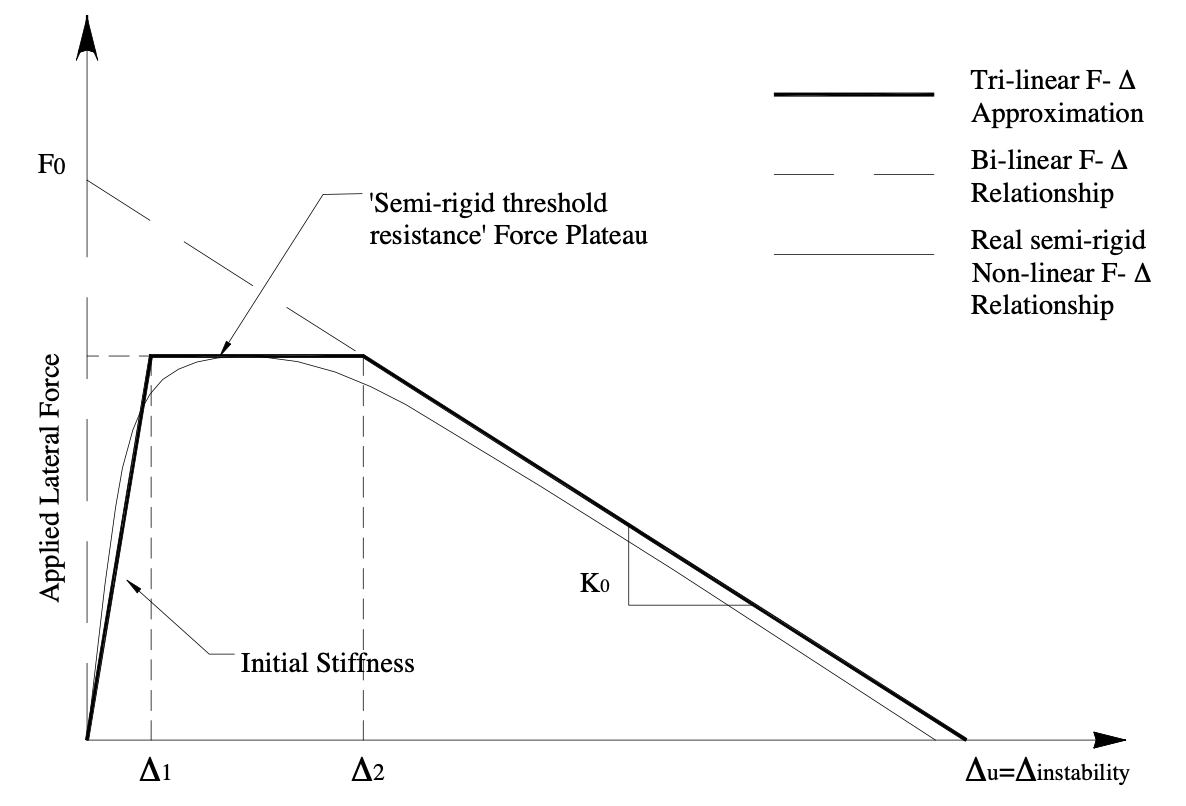

In [7]:
display(Image(filename='Griffith_Trilinear.png'))

In [8]:
agr = 0.152           # Horizontal ground acceleration [g] for a return period of 475 years (for the region of Petrinja)

# Choose the coefficients for the trilinear model per Griffith et al. (2003)
d1 = 0.075            # Range from 0.05 to 0.20
d2 = 0.5              # Range from 0.25 to 0.50

Response spectra are defined for single degree of freedom (DOF) systems. In this case, the mechanism involves more than one DOF. Thus, the capacity curve needs to be transformed into a capaciti curve for an equivalent SDOF system. Furthermore, after the transformation the pushover curve is aproximated as a tri-linear curve as proposed above (Griffith et al., 2003).

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]),
 [Text(0, -0.05, '−0.05'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.10000000000000002, '0.10'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.2, '0.20'),
  Text(0, 0.25000000000000006, '0.25'),
  Text(0, 0.30000000000000004, '0.30'),
  Text(0, 0.35000000000000003, '0.35'),
  Text(0, 0.4, '0.40'),
  Text(0, 0.45, '0.45')])

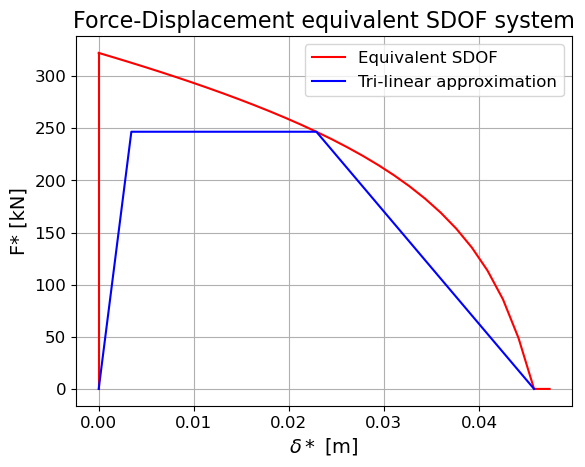

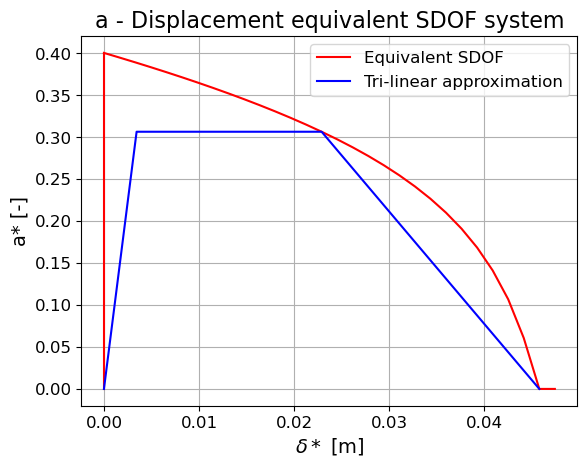

In [9]:
m = np.array([V_net1,V_net2])*rho_masonry                  # mass of wall [kg]
g = 9.81                                                   # gravitational constant [m/s^2]
Qs = np.sum(m)*agr*g                                       # seismic force acting at the gravity center of the wall [N]
phi = np.divide([(Htot-COG_1)/H1, COG_2/H2],(COG_2/H2))       # modal shape

# Effective properties of the SDOF system
m_star = np.dot(m,phi)                                     # effective mass (SDOF) [kg]
Gamma = m_star / np.dot(m,phi**2)                          # participation factor [-]
Fb = q_tot_vals * 1000                                     # total shear force [N]
F_star = Fb/Gamma                                          # equivalent shear force [N]
d_2 = delta_vals/H2*COG_2                                  # displacement at COG of lower block [m]
phi2 = phi[1]                                              # modal value at COG of lower block [-]
d_star = d_2/(Gamma*phi2)                                  # effective displacement (SDOF) [m]
a_star = F_star/m_star                                     # effective acceleration (SDOF) [m/s^2]

# Tri-linear approximation of the pushover curve according to  Griffith et al. (2003)
[a_1,F1]=alpha_fun(d1*delta_max)
[a_2,F1]=alpha_fun(d2*delta_max)
F_star1 = a_1*(G1+G2)/Gamma
F_star2 = a_2*(G1+G2)/Gamma
a_star1 = F_star1/m_star
a_star2 = F_star2/m_star
d_star1 = (d1*delta_max)/H2*COG_2/(Gamma*phi2)
d_star2 = (d2*delta_max)/H2*COG_2/(Gamma*phi2)
d_star_max = d_star[-2]
F_star_max = F_star2
F_star_app = [0,F_star_max, F_star_max,0]
d_star_app = [0,d_star1,d_star2,d_star_max]
a_star_app = F_star_app/m_star
a_star_max = F_star_max/m_star

# Displacement capacities according to EN 1998-3
d_u1 = 0.4*d_star_max
d_u2 = 0.6*d_star_max

# Pushover curve of the equivalent SDOF Force-Displacement
plt.figure()
plt.grid()
plt.plot([0,0],[0,F_star[0]/1000],color='red')
plt.plot(d_star,np.divide(F_star,1000),label='Equivalent SDOF',color='red')
plt.plot(d_star_app,np.divide(F_star_app,1000),label='Tri-linear approximation',color='blue')

plt.legend(fontsize=12)
plt.xlabel('$\delta*$ [m]', fontsize=14)
plt.ylabel('F* [kN]', fontsize=14)
plt.title('Force-Displacement equivalent SDOF system', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Pushover curve of the equivalent SDOF Acceleration-Displacement
plt.figure()
plt.grid()
plt.plot([0,0],[0,a_star[0]],color='red')
plt.plot(d_star,a_star,label='Equivalent SDOF',color='red')
plt.plot(d_star_app,a_star_app,label='Tri-linear approximation',color='blue')
plt.legend(fontsize=12)
plt.xlabel('$\delta*$ [m]', fontsize=14)
plt.ylabel('a* [-]', fontsize=14)
plt.title('a - Displacement equivalent SDOF system', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

To compute the response spectrum, it is necessary to specify the soil type per SIA 261 Tableau 24 or the Eurocode National Annex for a particular country.

Alternatively, sometimes the response spectra are defined according to the limit state for analysis. The available limit states are: 'serviceability', 'damage limitation', 'significant damage' or 'near collapse. More information can be found in EC 8 chapter 4.2.3. 

After the computation of the response spectrum, the capacity curve of the equivalent SDOF system can be plotted alongside the acceleration-displacement response spectrum. This provides a direct comparison between the specific behavior of the elements in question (in this case, the wall) and the spectrum of the desired limit state (either serviceability state, damage limitation, significant damage, or near collapse), and it can quickly give the spectral acceleration for a certain spectral displacement. 

This displacement-based evaluation utilizes the equal displacement "rule" for periods smaller than $T_c$ and the equal energy "rule" for periods larger than $T_c$. Thus, to interpret the results, extend the initial positive linear part of the capacity curve until it intersects the ADRS, and draw a vertical line at this intersection. If $T < T_c$, the actual displacement will be slightly larger than the displacement at the intersection of the capacity curve and the vertical line; if $T > T_c$, the actual displacement will be equivalent to the displacement at the intersection of the capacity curve and the vertical line. The displacement capacity is exceeded if the determined displacement is larger than the end of the capacity curve. 

In [10]:
soil_type = 'E'        # specify the soil type (ranging from A to E)

In [11]:
## Determine the periods that define the spectrum according to the soil type, with values from SIA 261 Tab. 24
def spectrum_vals(soil_type): 
    if soil_type == 'A':
        S = 1.00                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.40                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'B':
        S = 1.20                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'C':
        S = 1.15                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.60                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'D':
        S = 1.35                                 # [-]
        Tb = 0.20                                # [s]
        Tc = 0.80                                # [s]
        Td = 2.00                                # [s]
    elif soil_type == 'E':
        S = 1.40                                 # [-]
        Tb = 0.15                                # [s]
        Tc = 0.50                                # [s]
        Td = 2.00                                # [s]
    
    return S,Tb,Tc,Td

## Determine the spectral acceleration according to the structure's fundamental period
def RS(T,agr,S,Tb,Tc,Td):

    # determine spectral ground acceleration for dimensionning 
    g = 9.81                                     # [m/s^2]
    agd = agr*g                                  # [m/s^2]
    zeta = 0.05                                  # assume damping ratio to be 5% [-]
    eta = max(np.sqrt(1/(0.5+10*zeta)),0.55)     # reduction coefficent [-]

    # compute spectrum according to period
    if T<Tb: 
        Se = agd*S*(1+(T/Tb)*(eta*2.5-1))
    elif T>=Tb and T<Tc:
        Se = agd*S*eta*2.5
    elif T>=Tc and T<Td:
        Se = agd*S*eta*2.5*(Tc/T)
    else:
        Se = agd*S*eta*2.5*(Tc*Td/T**2)

    return Se

The target displacement NC is of d=0.044 m
The NC limit displacement is d_u2=0.027 m
Therefore the NC limit state is NOT verified!!!!


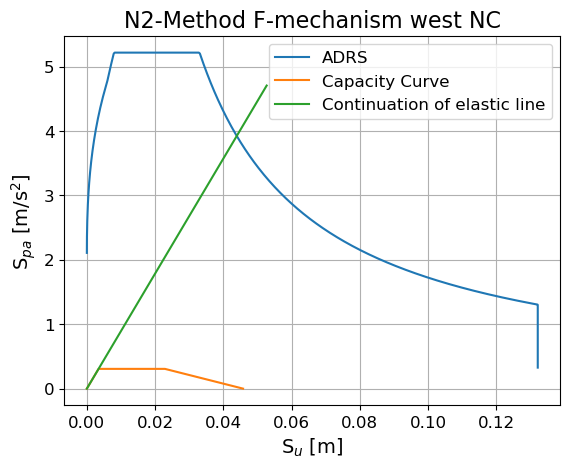

In [12]:
## Compute ADRS
# Initialize vectors
T_vals = np.array(np.linspace(0.001,4,1000))
Su_vals = np.zeros((len(T_vals),1))
Se_vals = np.zeros((len(T_vals),1))
[S,Tb,Tc,Td] = spectrum_vals(soil_type)

for i in range(0,1000):
    omega = 2*np.pi/T_vals[i]                                           # natural frequency [rad/s]
    Se_vals[i] = RS(T_vals[i],agr,S,Tb,Tc,Td)                           # spectral acceleration [m/s^2]
    if T_vals[i] < Tc: 
        Ry = max(Se_vals[i]*m_star/Qs,1)                                # R relationship [-]
        wd_int = ((Ry-1)*Tc/T_vals[i] + 1)*Se_vals[i]/((omega**2)*Ry)   # displacement capacity [m]
        Su_vals[i] = min(wd_int,3*Se_vals[i]/omega**2)                  # spectral displacement capacity [m]
    else:
        Su_vals[i] = Se_vals[i]/(omega**2)                              # spectral displacement capacity [m]

## Plot capacity curve NC
# plot results
plt.figure()
plt.grid()
plt.plot(Su_vals,Se_vals,label='ADRS')
plt.plot(d_star_app,a_star_app,label='Capacity Curve')
plt.plot(Su_vals[:round(len(Su_vals)/5)],Su_vals[:round(len(Su_vals)/5)]/d_star1*a_star_max,label="Continuation of elastic line")
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('S$_u$ [m]', fontsize=14)
plt.ylabel('S$_{pa}$ [m/s$^2$]', fontsize=14)
plt.title('N2-Method F-mechanism west NC', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

def find_closest_pair(d1, f1, d2, f2):
    
    data_set1 = np.column_stack((d1, f1))
    data_set2 = np.column_stack((d2, f2))

    min_distance = float('inf')
    closest_pair = None

    for point1 in data_set1:
        for point2 in data_set2:
            dist2d =point1 - point2
            distance = (dist2d[0]**2+dist2d[1]**2)**0.5
            if distance < min_distance:
                min_distance = distance
                closest_pair = (point1[0], point1[1], point2[0], point2[1])

    return closest_pair


closest = find_closest_pair(Su_vals, Se_vals, Su_vals[:round(len(Su_vals)/5)],Su_vals[:round(len(Su_vals)/5)]/d_star1*a_star_max)
target_disp_NC = (closest[0]+closest[2])/2

print(f"The target displacement NC is of d={round(target_disp_NC,3)} m")
print(f"The NC limit displacement is d_u2={round(d_u2,3)} m")
if target_disp_NC<=d_u2:
    print('Therefore the NC limit state is verified')
else:
    print('Therefore the NC limit state is NOT verified!!!!')

The target displacement DL is of d=0.022 m
The DL limit displacement is d_u1=0.018 m
Therefore the DL limit state is NOT verified!!!!


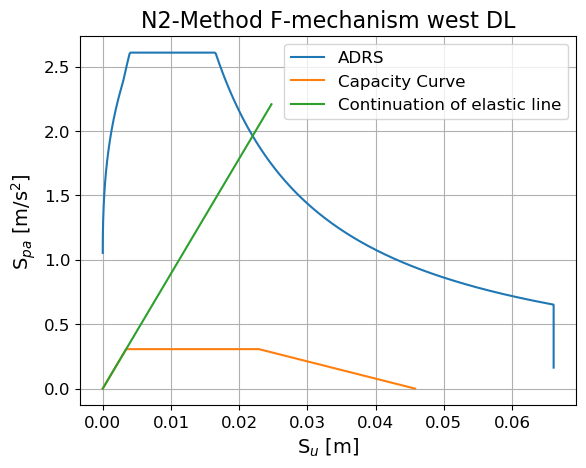

In [13]:
## Plot capacity curve DL
# plot results
plt.figure()
plt.grid()
plt.plot(0.5*Su_vals,0.5*Se_vals,label='ADRS')
plt.plot(d_star_app,a_star_app,label='Capacity Curve')
plt.plot(Su_vals[:round(len(Su_vals)/10)],Su_vals[:round(len(Su_vals)/10)]/d_star1*a_star_max,label="Continuation of elastic line")
plt.legend(fontsize=12, loc='upper right')
plt.xlabel('S$_u$ [m]', fontsize=14)
plt.ylabel('S$_{pa}$ [m/s$^2$]', fontsize=14)
plt.title('N2-Method F-mechanism west DL', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

closest = find_closest_pair(0.5*Su_vals, 0.5*Se_vals, Su_vals[:round(len(Su_vals)/10)],Su_vals[:round(len(Su_vals)/10)]/d_star1*a_star_max)
target_disp_DL = (closest[0]+closest[2])/2

print(f"The target displacement DL is of d={round(target_disp_DL,3)} m")
print(f"The DL limit displacement is d_u1={round(d_u1,3)} m")
if target_disp_DL<=d_u1:
    print('Therefore the DL limit state is verified')
else:
    print('Therefore the DL limit state is NOT verified!!!!')



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ec31d9b1-b904-46de-90ff-bc7ed068e5e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>